In [1]:
# check flux updates

In [2]:
%run tools.ipynb

In [3]:
#convert kg/m2/s to kg/3hours
# TODO: make it more general, take input temporal resolution in hours???
def unit_convert_3hour(dr, res_lat, res_lon):
    # use grid area function
    for ilat, lat in enumerate(dr.lat.values):
        area = 1e6 * area_latlon(lat1 = lat, lat2 = lat + res_lat,
                                 lon1 = 10, lon2 = 10 + res_lon) # m^2, longitude doesn't matter
        dr[:,ilat,:] = dr[:,ilat,:] * area * (3600*3) # kg/3hours
    return dr

In [4]:
def regional_monthly_bio(fname): 
    ds_original = xr.open_dataset(fname)

    dr_unit = ds_original['CO2'].copy()
    dr_output = unit_convert_3hour(dr_unit, 1., 1.25) # unit converted to kg/3hours per grid cell

    # compute regional total
    data = ds_original['CO2'].copy()
    # create masks for this resolution
    dr_mask = data[0,:,:]
    # create masks for input file
    mask = create_masks(input_file=dr_mask, 
                        input_file_type='dataarray', 
                        var_name='', 
                        mask_type='giorgi', 
                        output_format='xarray', 
                        output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                        figure_flag = False, 
                        figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')
    # split a mask into separate dataarrays (one dataset), with 1s and 0s
    ds_mask_splits = split_mask(input_mask = mask)

    # sum up monthly from 3 hourly data
    dr_monthly = ds_original['CO2'][:12,:,:].copy()
    dr_monthly[:,:,:] = 0.
    # fix time dimension
    months = np.arange('2016-01', '2017-02', dtype='datetime64[M]')
    dr_monthly['time'] = months[:12]

    for i in range(12):
        before = dr_output.sel(time = slice(months[i], months[i+1]))
        dr_monthly[i,:,:] = before.sum(axis=0) # unit: kgCO2/month
    
    # monthly regional total flux
    nx = 22
    monthly_bio_flux = np.zeros((12,nx))

    for i in range(12):
        for j in range(nx):
            mask_name = 'MASK' + str(j+1)
            tmp = dr_monthly[i,:,:] * ds_mask_splits[mask_name]
            monthly_bio_flux[i,j] = tmp.sum().values*1e-12*12/44 # unit: PgC/month

    print('Biospheric annual flux (PgC/year): ', np.sum(monthly_bio_flux))
    return monthly_bio_flux


In [ ]:
%%time

#last_month = 12 # last month available
#fig_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-test-2018/nd51/plots/'

# original biospheric flux
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc'
regional_before = regional_monthly_bio(fname)
global_before = np.sum(regional_before, axis = 1) # global

# updated biospheric flux
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.updated.Jan.nc'
regional_after = regional_monthly_bio(fname)
global_after = np.sum(regional_after, axis = 1) # global


In [9]:
diff = regional_after[0] - regional_before[0]


In [10]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values

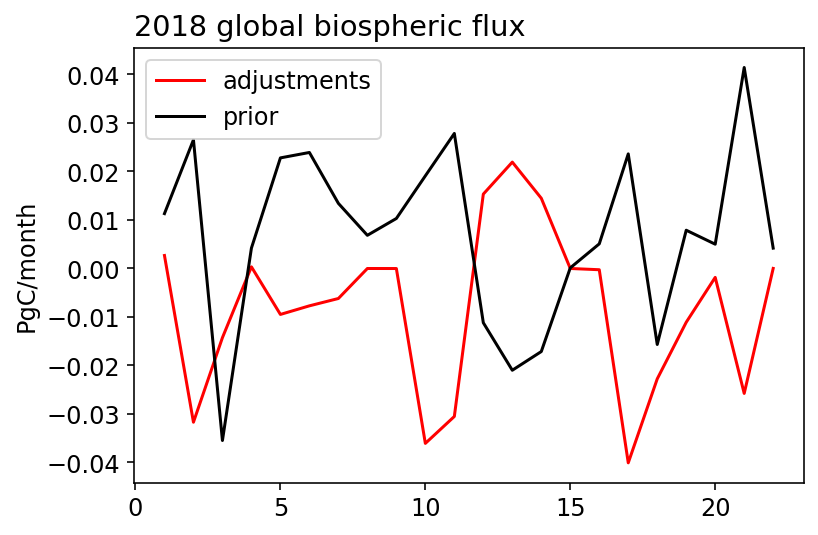

In [12]:
# plot
fig, ax = plt.subplots()
ax.plot(range(1,23), diff, label = 'adjustments', color = 'red')
ax.plot(range(1,23), regional_before[0], label = 'prior', color = 'black')
    
plt.title('2018 global biospheric flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()
#fig.savefig(fig_dir + 'inversion_lag_window.png', dpi = 300)

finished creating masks for giorgi
Biospheric annual flux (PgC/year):  3.3676737659711726


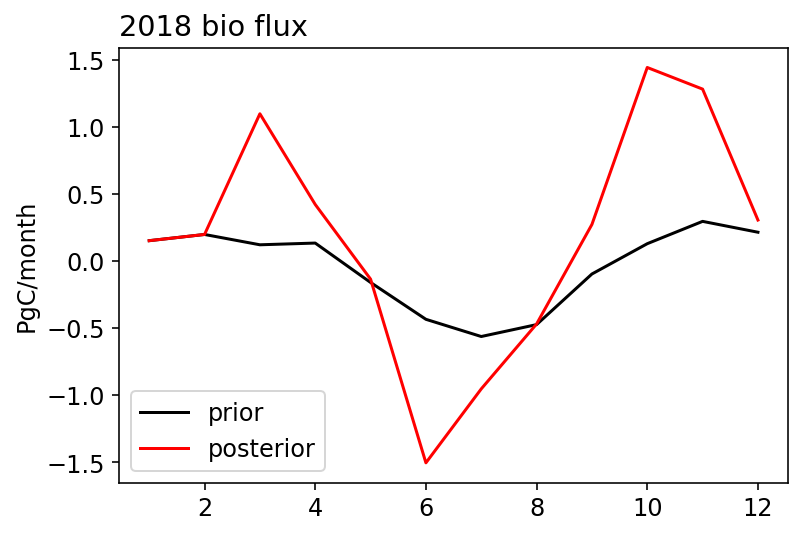

In [6]:

last_fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.updated.' + short_name_of_month(last_month) + '.nc'
regional_after = regional_monthly_bio(fname)
regional_after[0:2,:] = regional_before[0:2,:]
global_after = np.sum(regional_after, axis = 1) # global net flux


fig, ax = plt.subplots()
# prior
ax.plot(range(1,13), global_before, label = 'prior', color = 'black')
ax.plot(range(1,13), global_after, label = 'posterior', color = 'red')

plt.title('2018 bio flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()


In [7]:
# all fluxes used in simulations
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/monthly_emission.nc'
ds_monthly = xr.open_dataset(fname)
dr_monthly = ds_monthly['ff'] # just for making a mask

# create masks for this resolution
dr = dr_monthly[0,:,:]
# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

# split masks into separate dataarrays, with 1 for masked area, 0 for elsewhere
target = dr.copy()
target[:,:] = 0.
ds_masks = target.to_dataset(name = 'MASK1')

nm_masks = int(mask.max().values) # number of masks
for count in range(1,nm_masks+1): # + ocean
    target = dr.copy()
    target[:,:] = 0.
        
    mask_TF = mask == count # True or False map
    target = mask_TF.where(True)
    name_tmp = 'MASK' + str(count)
    ds_masks[name_tmp] = target

# monthly net fluxes for 22 tagged regions
monthly_net_flux_casa = np.zeros((12,nm_masks+1))
dr_monthly = ds_monthly['ff'] + ds_monthly['fire'] + ds_monthly['ocean'] + ds_monthly['nte'] + ds_monthly['casa_bio']

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        monthly_net_flux_casa[i,j] = tmp.sum().values*1e-12*12/44
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12*12/44
    masked_sum = sum(monthly_net_flux_casa[i,:])
    monthly_net_flux_casa[i,-1] = sum_tmp - masked_sum

net_flux_2018 = np.sum(monthly_net_flux_casa, axis = 1) # global net flux
print('My annual total net flux w/ CASA (PgC/year): ', np.sum(net_flux_2018))


finished creating masks for giorgi
My annual total net flux w/ CASA (PgC/year):  3.889662349684364


In [8]:
# Liang's posterior
fname = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/liang/oco2_v9_2014_2018_monthly_flux.nc'
ds_liang = xr.open_dataset(fname)
varname  = 'flux'           # unit: kgC/m2/d
dr_2018  = ds_liang[varname][-12:,:,:]/(24*3600) # 2018 monthly, unit convert to kgC/m2/s
dr_2018_monthly_total = unit_convert_monthly(dr_2018, 2018, 4., 5.)
print('Liang 2018 global net flux (PgC/year):', dr_2018_monthly_total.sum().values*1e-12)

# create masks for this resolution
dr = dr_2018_monthly_total[0,:,:]

# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

# split masks into separate dataarrays, with 1 for masked area, 0 for elsewhere
target = dr.copy()
target[:,:] = 0.
ds_masks = target.to_dataset(name = 'MASK1')

nm_masks = int(mask.max().values) # number of masks
for count in range(1,nm_masks+1): # + ocean
    target = dr.copy()
    target[:,:] = 0.
        
    mask_TF = mask == count # True or False map
    target = mask_TF.where(True)
    name_tmp = 'MASK' + str(count)
    ds_masks[name_tmp] = target
    
dr_monthly = dr_2018_monthly_total
# monthly net fluxes for 22 tagged regions
net_monthly_liang = np.zeros((12,nm_masks+1))

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        net_monthly_liang[i,j] = tmp.sum().values*1e-12
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12
    masked_sum = sum(net_monthly_liang[i,:])
    net_monthly_liang[i,-1] = sum_tmp - masked_sum

Liang_monthly_global = np.sum(net_monthly_liang, axis = 1)
print('check after applying masks: global net flux:', np.sum(net_monthly_liang))


Liang 2018 global net flux (PgC/year): 4.44784598339217
finished creating masks for giorgi
check after applying masks: global net flux: 4.447845983392172


My prior net: 3.89
My posterior net: 6.48
Liang's posterior net: 4.45


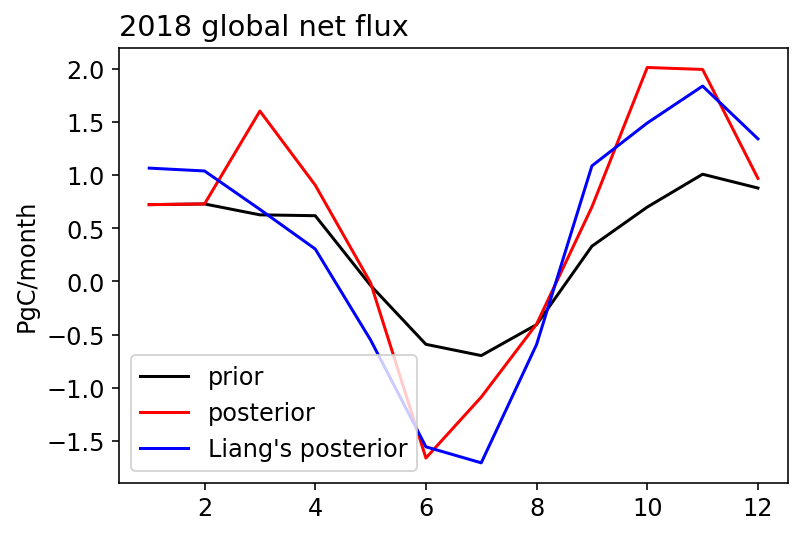

In [9]:
posterior = regional_after - regional_before + monthly_net_flux_casa
my_posterior = np.sum(posterior, axis = 1)

print('My prior net:', "{:.2f}".format(np.sum(monthly_net_flux_casa)))
print('My posterior net:', "{:.2f}".format(sum(my_posterior)))
print("Liang's posterior net:", "{:.2f}".format(sum(Liang_monthly_global)))

fig, ax = plt.subplots()
# prior
ax.plot(range(1,13), net_flux_2018, label = 'prior', color = 'black')
# posterior
ax.plot(range(1,13), my_posterior, label = 'posterior', color = 'red')
# liang posterior
ax.plot(range(1,13), Liang_monthly_global, label = "Liang's posterior", color = 'blue')
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()

fig.savefig(fig_dir + 'inversion_comparison.png', dpi = 300)


In [10]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values

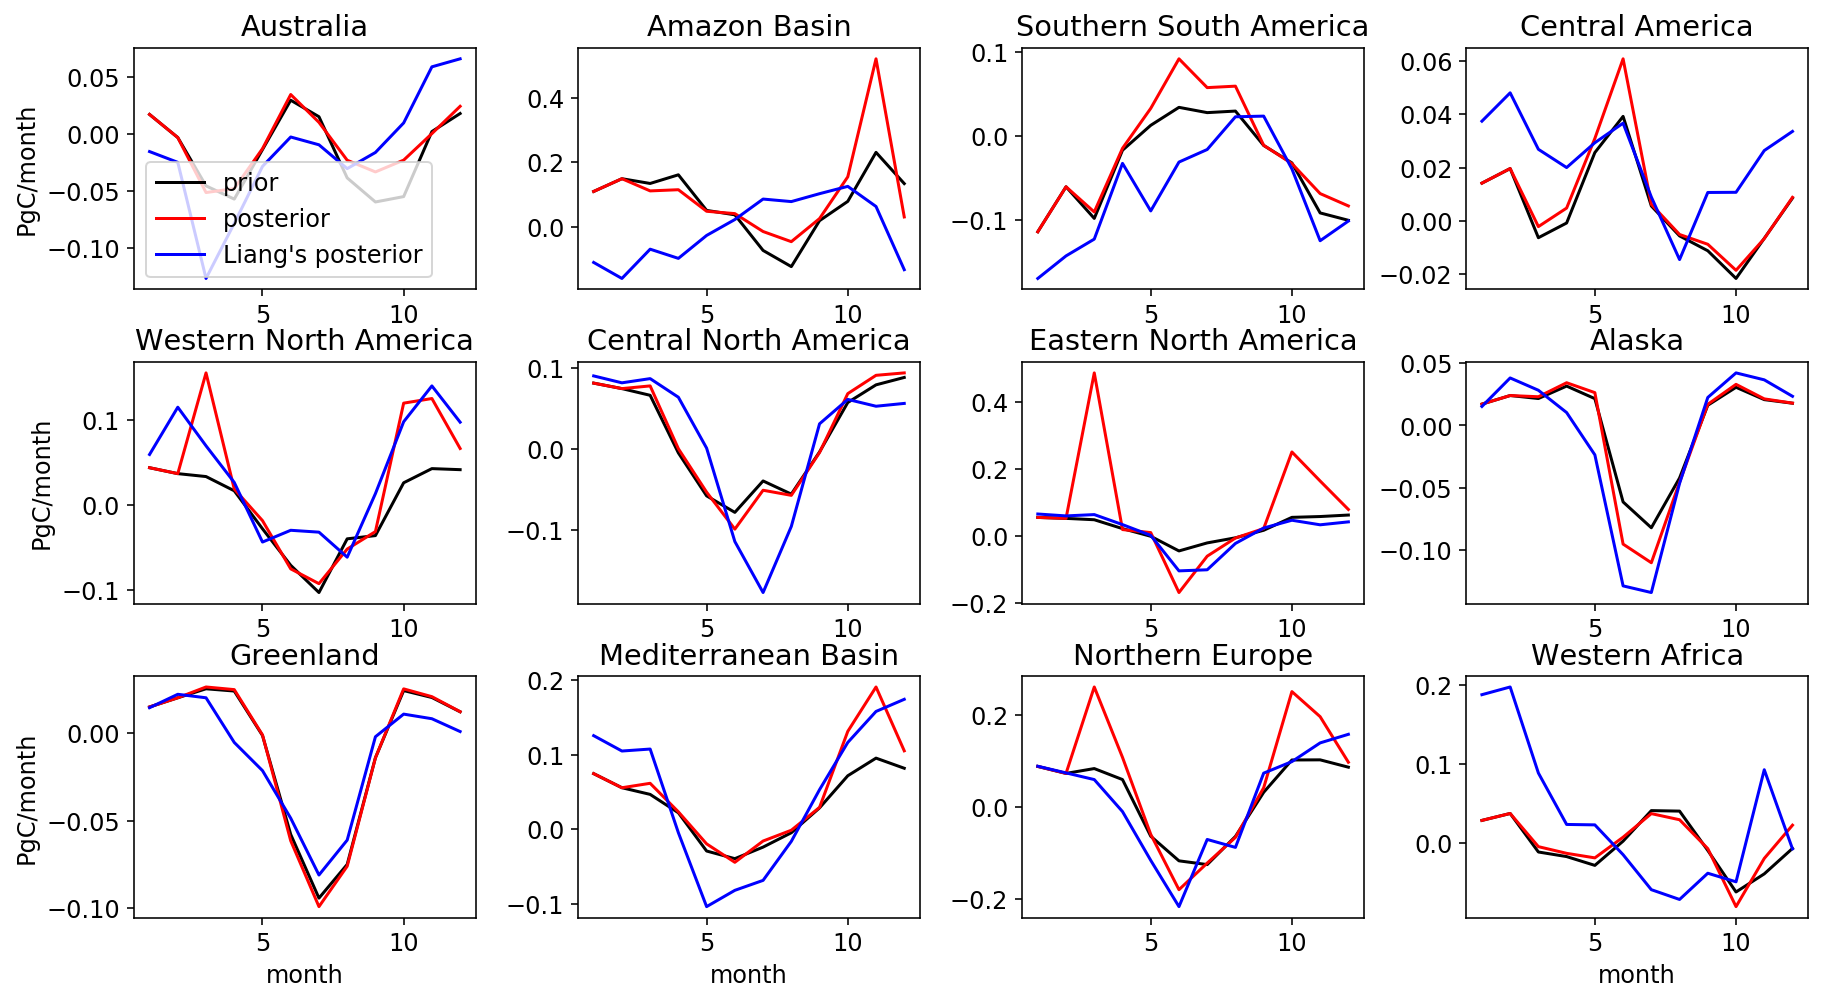

In [11]:
fig, axs = plt.subplots(3,4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(12):
    x = range(1,13)

    # casa
    y = monthly_net_flux_casa[:,i]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = posterior[:,i]
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    axs[i].set_title(region_names[i])
    
    # Liang's posterior
    y = net_monthly_liang[:,i]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[4].set_ylabel('PgC/month')
axs[8].set_ylabel('PgC/month')
axs[0].legend()

axs[8].set_xlabel('month')
axs[9].set_xlabel('month')
axs[11].set_xlabel('month')

fig.savefig(fig_dir + 'inversion_regions1.png', dpi = 300)


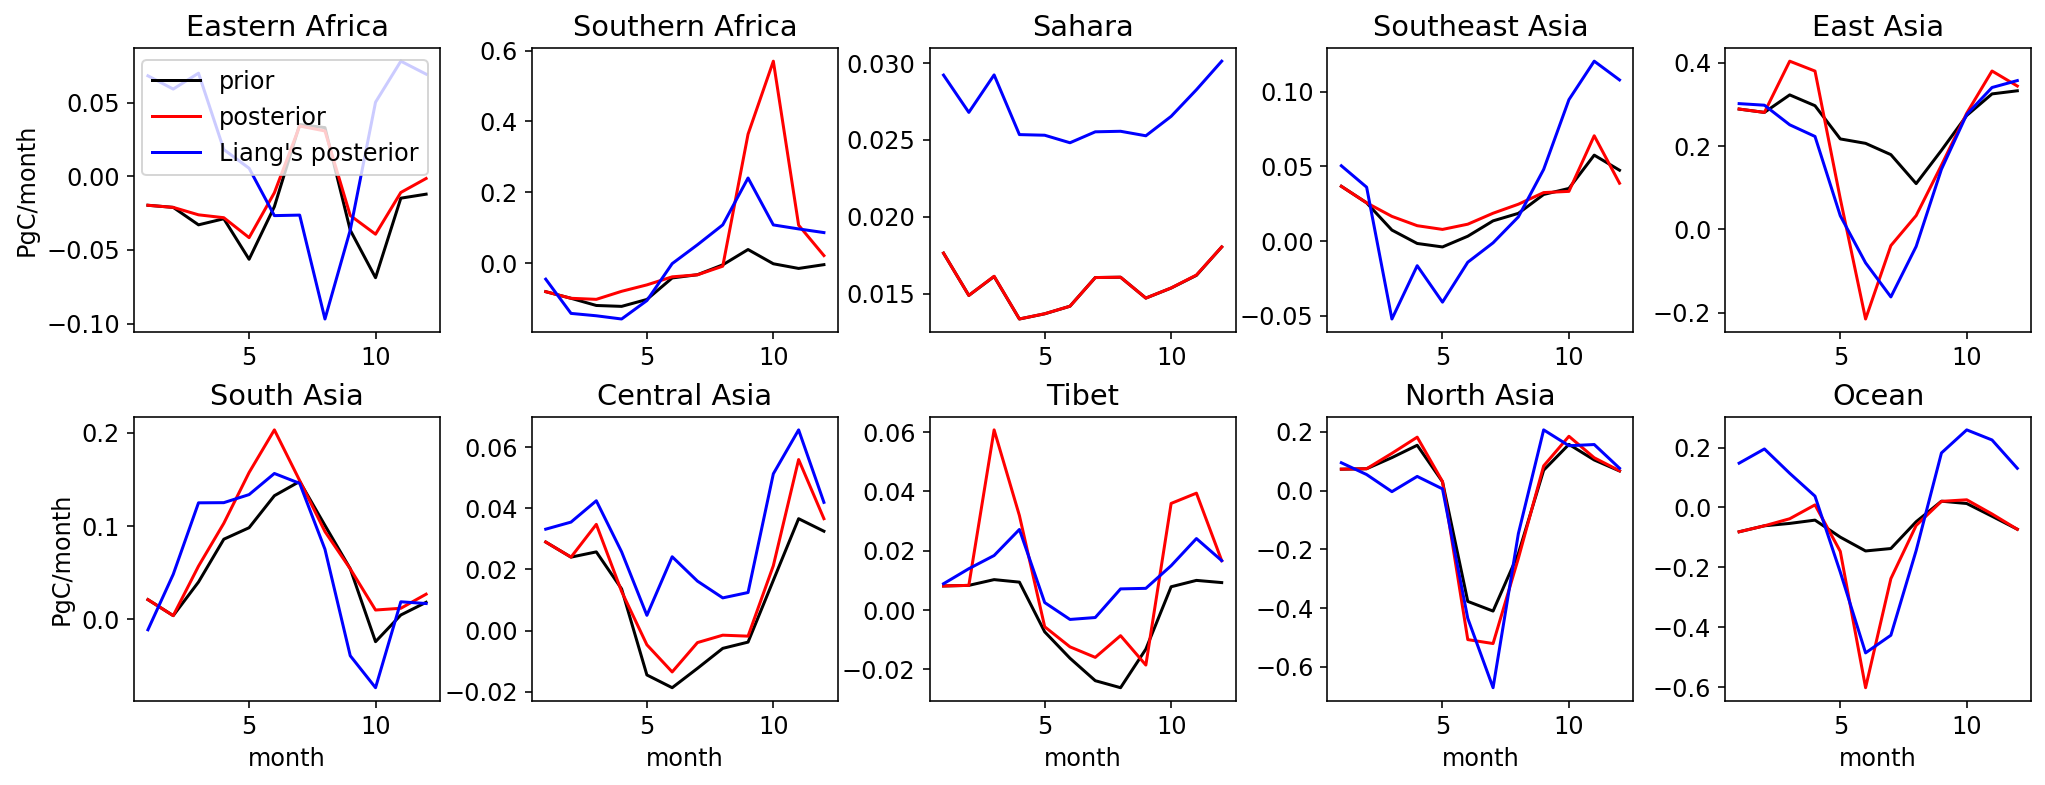

In [12]:
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(10):
    x = range(1,13)
    imonth = i+12

    # casa
    y = monthly_net_flux_casa[:,imonth]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = posterior[:,imonth]
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    axs[i].set_title(region_names[imonth])
    
    # Liang's posterior
    y = net_monthly_liang[:,imonth]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[5].set_ylabel('PgC/month')
axs[0].legend()

axs[5].set_xlabel('month')
axs[6].set_xlabel('month')
axs[7].set_xlabel('month')
axs[8].set_xlabel('month')
axs[9].set_xlabel('month')

fig.savefig(fig_dir + 'inversion_regions2.png', dpi = 300)


In [35]:

# all fluxes used in simulations
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/monthly_emission.nc'
ds_monthly = xr.open_dataset(fname)
net_monthly = ds_monthly['ff'] + ds_monthly['fire'] + ds_monthly['ocean'] + ds_monthly['nte'] + ds_monthly['casa_bio']
casa_monthly = ds_monthly['casa_bio']


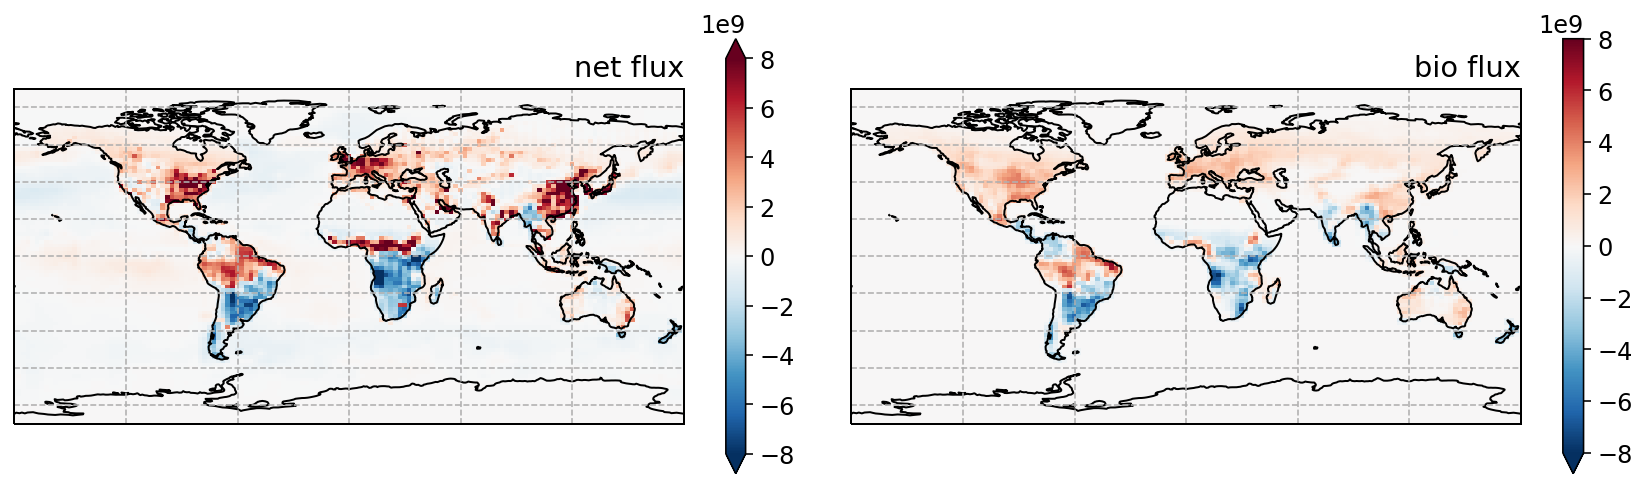

In [43]:
# multiply this scale map to bio flux
# plot updates during lag window
fig, axes = plt.subplots(1,2, figsize=[15, 5], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})


net_monthly[0,:,:].plot(ax = axes[0], cmap = 'RdBu_r', vmax = 8e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.8})
#axes[0].set_title(long_name_of_month(assim_month - lag_window + i + 1), loc='left')
axes[0].set_title('net flux', loc='right')
axes[0].coastlines()
axes[0].gridlines(linestyle = '--')

casa_monthly[0,:,:].plot(ax = axes[1], cmap = 'RdBu_r', vmax = 8e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.8})
axes[1].set_title('bio flux', loc='right')
axes[1].coastlines()
axes[1].gridlines(linestyle = '--')


#fig.savefig(mod_dir  + 'flux_scaling.' + short_name_of_month(assim_month) + '.update.png', dpi = 300)

